In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Cargar datos

In [2]:
# MINOS 
minos_data = pd.read_csv('minos_nh_ih/minos.3D.grid.of.sk.dm32.s2t13.s2t23.nh', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
# SK
sk_data = pd.read_csv('sk_nh_ih/sk-nh-ji.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
# DAYA BAY
db_data = pd.read_csv('daya_bay_nh_ih/db-3D-nh.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)
# RENO
reno_data = pd.read_csv('reno_nh_ih/reno-3D-nh.dat', names=['dm32','s2_t13','s2_t23','ji'], delim_whitespace=True)

In [3]:
def get_min_vals(df):
    
    idx_min    = df['ji'].idxmin()
    ji_min     = df['ji'][idx_min]
    dm32_min   = df['dm32'][idx_min]
    s2_t13_min = df['s2_t13'][idx_min]
    s2_t23_min = df['s2_t23'][idx_min]    
    
    return {'dm32_min':dm32_min,'s2_t13_min':s2_t13_min,'s2_t23_min':s2_t23_min,'ji_min':ji_min}

def get_normalize_data(df,minima_dic):
           
    df['ji']  = df['ji'] - minima_dic['ji_min']    
    print(minima_dic)
    
    return df

def get_data_to_plotter_1D(df,param):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        
        if(param=='dm32'):
            result = data[ ( data['s2_t13'] == dat_mins['s2_t13_min'] ) & ( data['s2_t23'] == dat_mins['s2_t23_min'] ) ]
            data = result[ ['dm32','ji'] ]
        elif(param=='s2_t13'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t23'] == dat_mins['s2_t23_min'])]
            data = result[['s2_t13','ji']]
        elif(param=='s2_t23'):
            result = data[(data['dm32']   == dat_mins['dm32_min']) & (data['s2_t13'] == dat_mins['s2_t13_min'])]
            data = result[['s2_t23','ji']]
        return data
    
def get_interpolated_data_1D(df,param,size):
    
    df = get_data_to_plotter_1D(df,param)
    
    x = df[param].values
    #x=np.append(x,x[-1]*(1.1))
    
    y = df.ji.values
    #y=np.append(y,y[-1]*y[-1]*15)
    
    f1 = interpolate.interp1d(x, y, kind = 'cubic')
    x_new = np.linspace(x[0], x[-1],size)
    y_new = f1(x_new)
    data_new = pd.DataFrame({param:x_new,'ji':y_new})
    
    idx_min        = data_new['ji'].idxmin()
    ji_min         = data_new['ji'][idx_min]
    data_new['ji'] = data_new['ji'] - ji_min
    
    return data_new

def get_data_to_plotter_2D(df,params):        
    
        dat_mins=get_min_vals(df)
        data=get_normalize_data(df,dat_mins)
        parameters = ['dm32','s2_t13','s2_t23']
        if ((params[0] not in parameters) or (params[1] not in parameters)): 
            print('Metiste mal los parametros a gráficas, deben ser: [dm32,s2_t13,s2_t23] ')
        else:            
            if(('dm32' in params) & ('s2_t13' in params)):                
                
                result = data[ data['s2_t23'] == dat_mins['s2_t23_min'] ]
                data   = result[ ['dm32','s2_t13','ji'] ]                
                
            elif(('dm32' in params) & ('s2_t23' in params)):

                result = data[ data['s2_t13'] == dat_mins['s2_t13_min'] ]
                data = result[ ['dm32','s2_t23','ji'] ]

            elif(('s2_t13' in params) & ('s2_t23' in params)):

                result = data[ data['dm32'] == dat_mins['dm32_min'] ]
                data = result[ ['s2_t13','s2_t23','ji'] ]

            else:
                print('La opción no existe')            
        return data

def get_interpolated_data_2D(df,params,size):
     
    df1 = get_data_to_plotter_2D(df,params)
    par =[]

    if(('dm32' in params) & ('s2_t13' in params)):
        par.append('dm32')
        par.append('s2_t13')
    elif(('dm32' in params) & ('s2_t23' in params)):            
        par.append('dm32')
        par.append('s2_t23')    
    elif(('s2_t13' in params) & ('s2_t23' in params)):
        par.append('s2_t13')
        par.append('s2_t23')
    else:
        print('La opción no existe')
        
     
    x=df1[par[0]].drop_duplicates().to_numpy()
    y=df1[par[1]].drop_duplicates().to_numpy() ###
    z=df1.ji.values                

    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new=np.linspace(x[0], x[-1],size)
    y_new=np.linspace(y[0], y[-1],size)
    z_for_my=f(x_new,y_new)
    z_for_my=z_for_my.T
    z_new=z_for_my.reshape(size*size)
    
    x=[]
    y=[]
    for i in x_new:
        for j in y_new:
            x.append(i)
            y.append(j)
    data_new = pd.DataFrame({par[0]:x,par[1]:y,'ji':z_new})      
    return data_new

# MINOS  - ( $\sin^2 \theta_{13}$, $\sin^2 \theta_{23}$, $\Delta m^2_{32}$ vs $\Delta \chi^2$)

In [4]:
def ploter_MINOS_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    fig, ax = plt.subplots()
    
    ax.plot(param, 'ji', data=r,label='MINOS',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)#, scatterpoints=1, )
    
    labels=[]    
    if(param=='dm32'):
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_MINOS_'+param+'_vs_ji.png')
    return   

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 57.13037584}


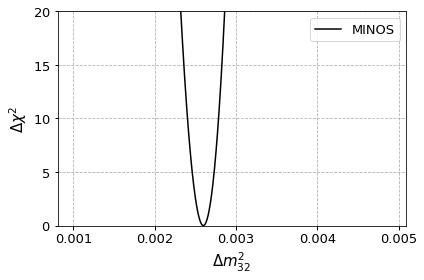

In [5]:
ploter_MINOS_profile(minos_data,'dm32',1000)

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


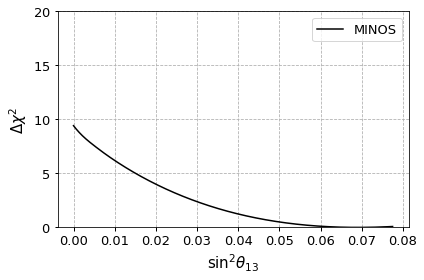

In [6]:
ploter_MINOS_profile(minos_data,'s2_t13',1000)

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


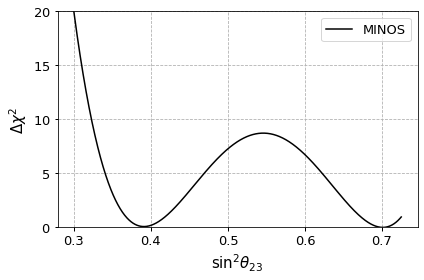

In [7]:
ploter_MINOS_profile(minos_data,'s2_t23',1000)

# MINOS  - ( 2D vs $\Delta \chi^2$)

In [8]:
def ploter_MINOS_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30) & (df['ji']  >=  2.15) ]    
    cl_90 = df[ (df['ji']  <=  4.61) & (df['ji']  >=  4.51) ]
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0., 0.08)
        ax.set_xticks([0.,0.02,0.04,0.06,0.08])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$','$0.08$'])
        
        ax.set_ylim(0.002, 0.003)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003,0.0032])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$','$3.2$'])
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')
        ax.set_xlim(0., 0.08)
        ax.set_xticks([0.,0.02,0.04,0.06,0.08])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$','$0.08$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
        
    ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='MINOS')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_MINOS_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


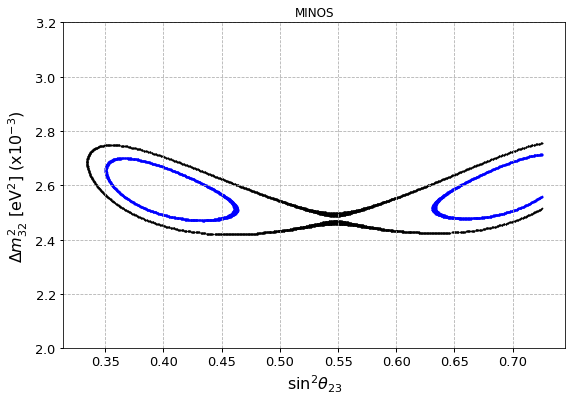

In [9]:
ploter_MINOS_confidence_regions(minos_data,['dm32','s2_t23'],1800)

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


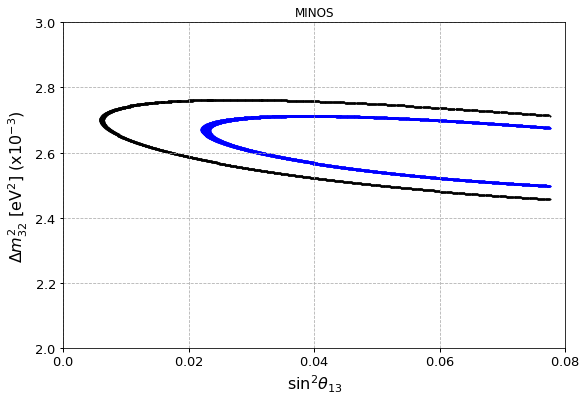

In [10]:
ploter_MINOS_confidence_regions(minos_data,['s2_t13','dm32'],2500)

{'dm32_min': 0.0026, 's2_t13_min': 0.07, 's2_t23_min': 0.7, 'ji_min': 0.0}


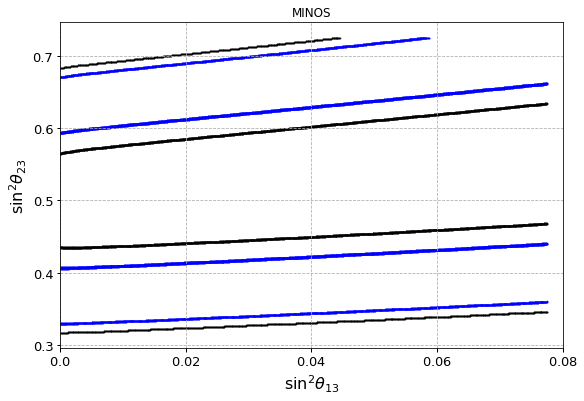

In [11]:
ploter_MINOS_confidence_regions(minos_data,['s2_t23','s2_t13'],1000)

# SK  - ( 1D vs $\Delta \chi^2$)

In [12]:
def ploter_SK_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Super-Kamiokande',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.001, 0.005)
        ax.set_xticks([0.001,0.002,0.003,0.004,0.005])
        ax.set_xticklabels(['$1.0$','$2.0$','$3.0$','$4.0$','$5.0$'])
        
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        ax.set_xlim(0.00, 0.07)
        ax.set_xticks([0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07])
        ax.set_xticklabels(['$0.0$','$0.01$','$0.02$','$0.03$','$0.04$','$0.05$','$0.06$','$0.07$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_SK_'+param+'_vs_ji.png')
    return   

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 1.9669999999999999}


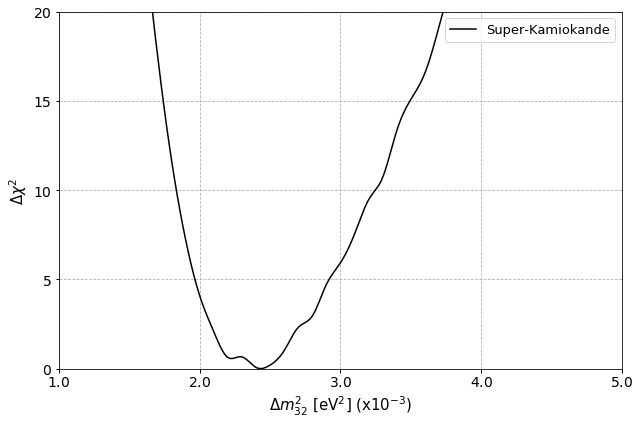

In [13]:
ploter_SK_profile(sk_data,'dm32',200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}


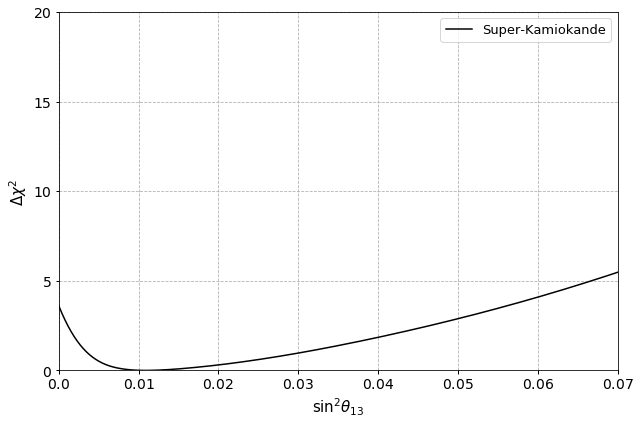

In [14]:
ploter_SK_profile(sk_data,'s2_t13',200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}


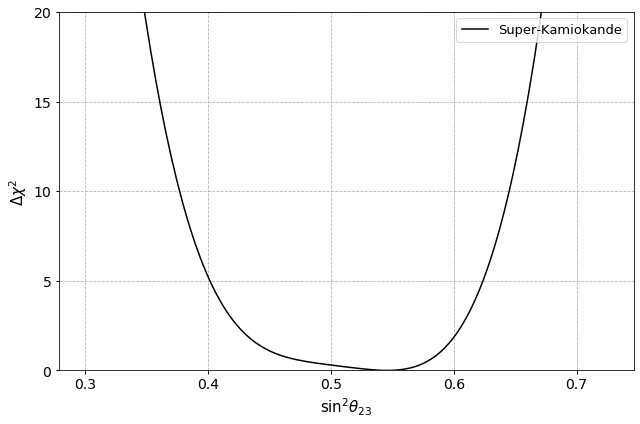

In [15]:
ploter_SK_profile(sk_data,'s2_t23',200)

# SK  - ( 2D vs $\Delta \chi^2$)

In [16]:
def ploter_SK_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    #cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.0, 0.07)
        ax.set_xticks([0.,0.02,0.04,0.06])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.0015, 0.0035)   
        ax.set_yticks([0.0015,0.0020,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$1.5$','$2.0$','$2.5$','$3.0$','$3.5$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        #ax.set_xlim(0.2, 0.8)
        #ax.set_xticks([0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(['$0.2$','$0.4$','$0.6$','$0.8$'])
        
        ax.set_ylim(0.0015, 0.0035)   
        ax.set_yticks([0.0015,0.0020,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$1.5$','$2.0$','$2.5$','$3.0$','$3.5$'])
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')
        ax.set_xlim(0.0, 0.07)
        ax.set_xticks([0.,0.02,0.04,0.06])
        ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.3, 0.7)
        ax.set_yticks([0.30,0.40,0.5,0.60,0.70])
        ax.set_yticklabels(['$3.0$','$4.0$','$5.0$','$6.0$','$7.0$'])
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    #ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Super-Kamiokande')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_SK_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}


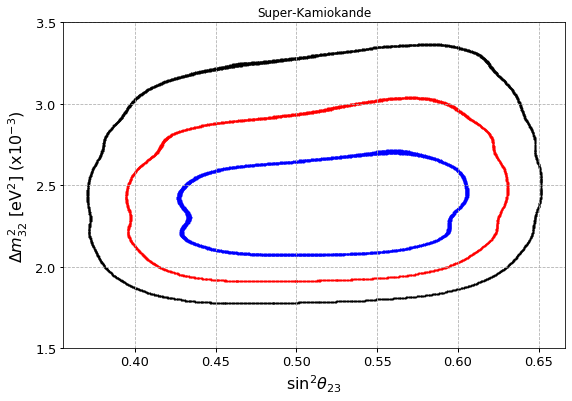

In [17]:
ploter_SK_confidence_regions(sk_data,['dm32','s2_t23'],1200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}


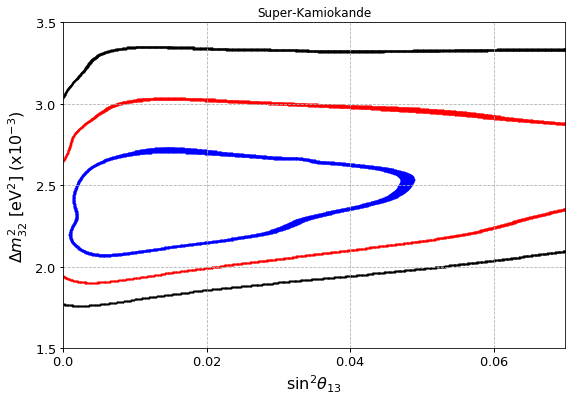

In [18]:
ploter_SK_confidence_regions(sk_data,['dm32','s2_t13'],1200)

{'dm32_min': 0.0024, 's2_t13_min': 0.01, 's2_t23_min': 0.55, 'ji_min': 0.0}


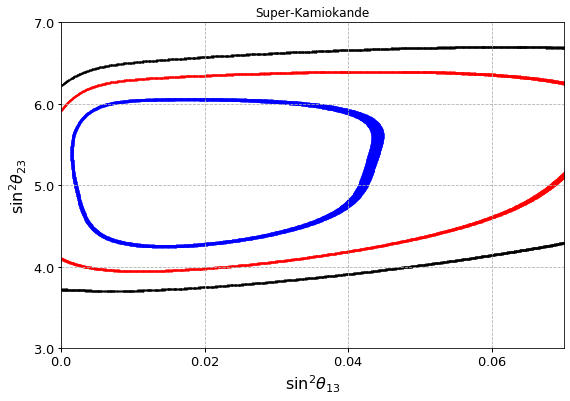

In [19]:
ploter_SK_confidence_regions(sk_data,['s2_t13','s2_t23'],1200)

# Daya Bay  - ( 1D vs $\Delta \chi^2$)

In [20]:
def ploter_DB_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Daya Bay',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.003)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        #ax.set_ylim(0, 20)   
       #ax.set_yticks([0,5,10,15,20])
       # ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_DB_'+param+'_vs_ji.png')
    return   

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 151.88171892459937}


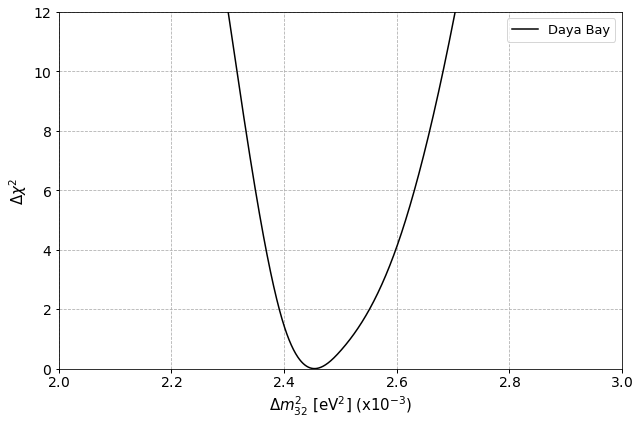

In [21]:
ploter_DB_profile(db_data,'dm32',5000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


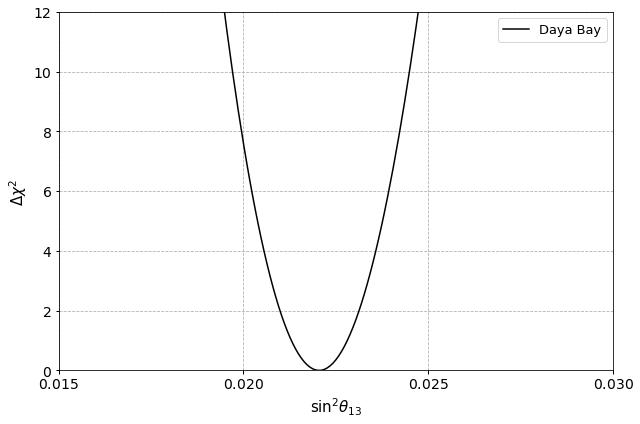

In [22]:
ploter_DB_profile(db_data,'s2_t13',1000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


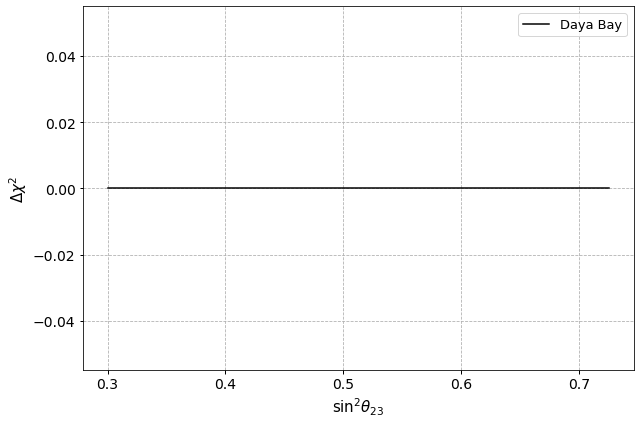

In [23]:
ploter_DB_profile(db_data,'s2_t23',1000)

# Daya Bay  - ( 2D vs $\Delta \chi^2$)

In [24]:
def ploter_DB_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    #cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        #ax.set_xlim(0.0, 0.07)
        #ax.set_xticks([0.,0.02,0.04,0.06])
        #ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    #ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Daya Bay')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_DB_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


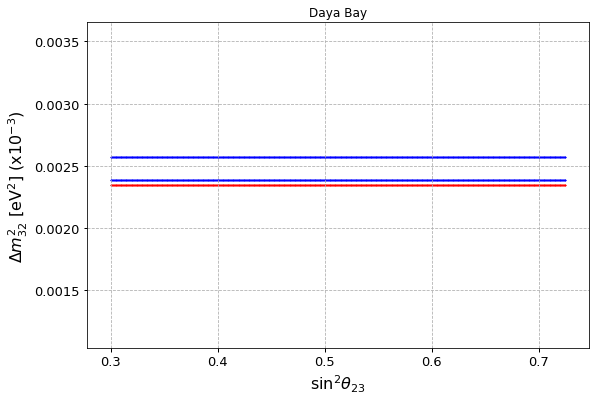

In [25]:
ploter_DB_confidence_regions(db_data,['dm32','s2_t23'],1000)

In [ ]:
ploter_DB_confidence_regions(db_data,['dm32','s2_t13'],4000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


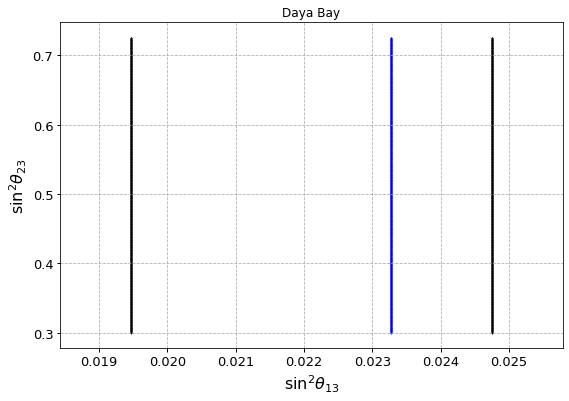

In [27]:
ploter_DB_confidence_regions(db_data,['s2_t23','s2_t13'],1000)

# RENO  - ( 1D vs $\Delta \chi^2$)

In [28]:
def ploter_RENO_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='RENO',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.0035)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003,0.0032,0.0034])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$','$3.2$','$3.4$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        #ax.set_ylim(0, 20)   
       #ax.set_yticks([0,5,10,15,20])
       # ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_RENO_'+param+'_vs_ji.png')
    return  

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 16.69100275212546}


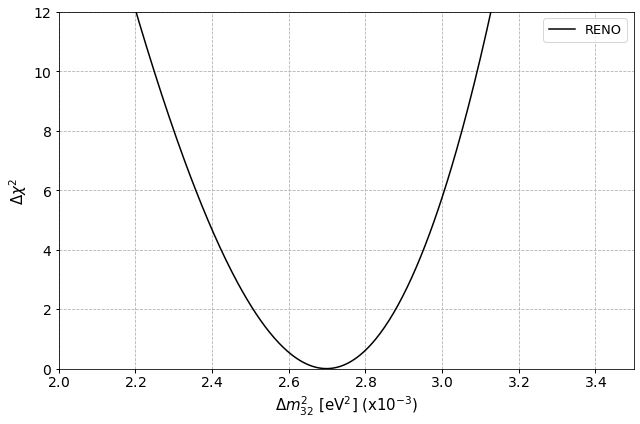

In [29]:
ploter_RENO_profile(reno_data,'dm32',1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


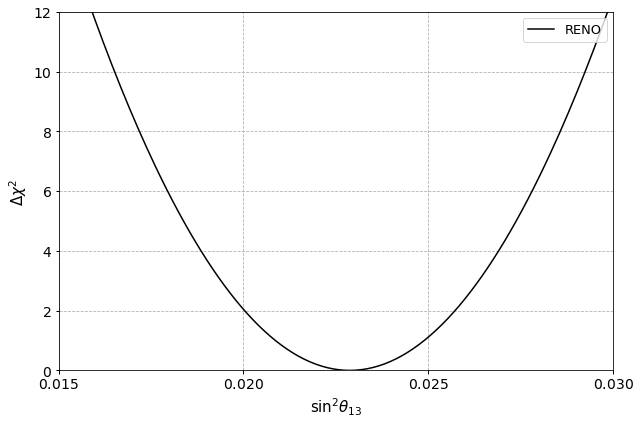

In [30]:
ploter_RENO_profile(reno_data,'s2_t13',1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


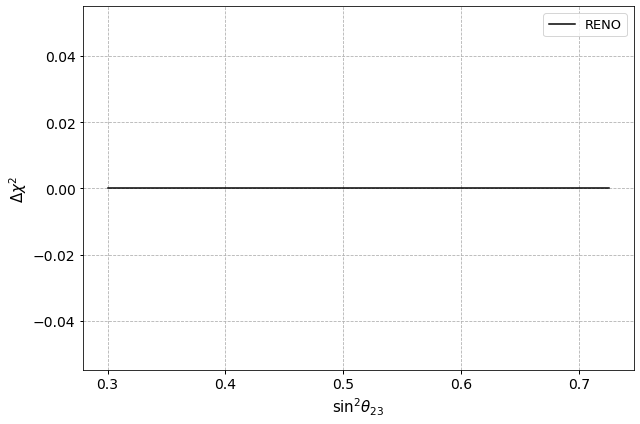

In [31]:
ploter_RENO_profile(reno_data,'s2_t23',1000)

# RENO  - ( 2D vs $\Delta \chi^2$)

In [32]:
def ploter_RENO_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    #cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.015, 0.032)
        #ax.set_xticks([0.,0.02,0.04,0.06])
        #ax.set_xticklabels(['$0.0$','$0.02$','$0.04$','$0.06$'])
        
        ax.set_ylim(0.002, 0.0035)   
        ax.set_yticks([0.002,0.0025,0.0030,0.0035])
        ax.set_yticklabels(['$2.0$','$2.5$','$3.0$','$3.5$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')        
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    #ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='RENO')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_RENO_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


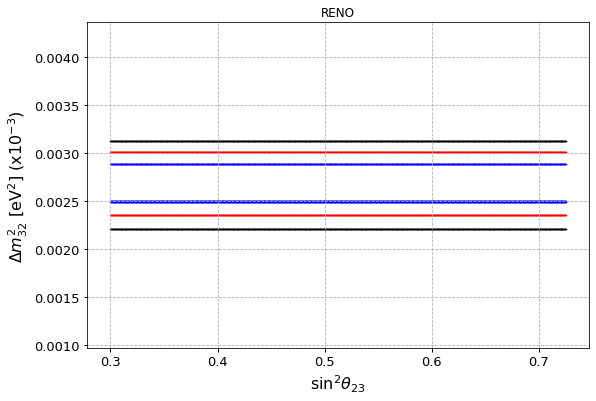

In [33]:
ploter_RENO_confidence_regions(reno_data,['dm32','s2_t23'],1000)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


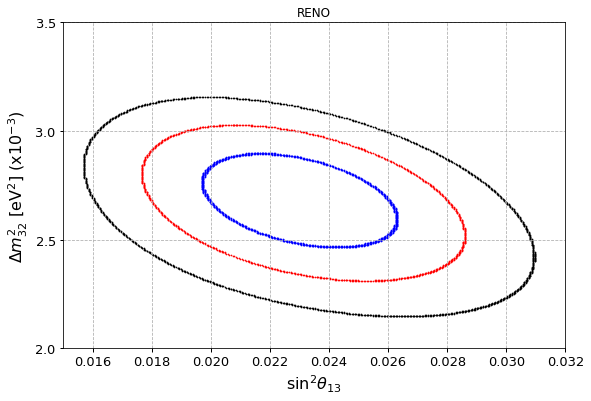

In [34]:
ploter_RENO_confidence_regions(reno_data,['dm32','s2_t13'],1500)

{'dm32_min': 0.0027, 's2_t13_min': 0.0225, 's2_t23_min': 0.3, 'ji_min': 0.0}


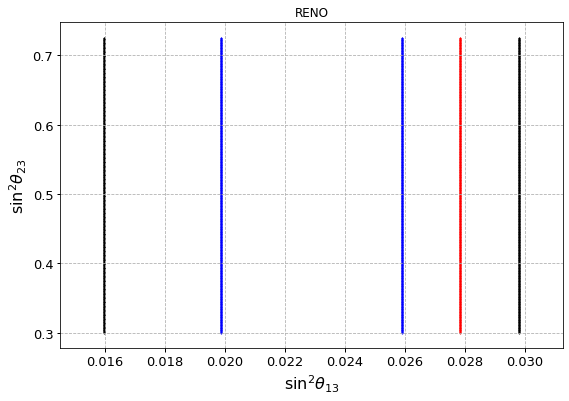

In [35]:
ploter_RENO_confidence_regions(reno_data,['s2_t23','s2_t13'],1000)

# Análisis unificado

In [36]:
#sk_data,reno_data,minos_data,db_data
sum_ji = sk_data['ji']+reno_data['ji']+minos_data['ji']+db_data['ji']

In [37]:
total_data = pd.DataFrame({'dm32':sk_data.dm32, 's2_t13':sk_data.s2_t13, 's2_t23':sk_data.s2_t23, 'ji':sum_ji})

In [38]:
sk_data['ji'][44795]+reno_data['ji'][44795]+minos_data['ji'][44795]+db_data['ji'][44795]

5402.726740154819

## Unificado 1D vs $\Delta \chi^2$

In [39]:
def ploter_UNIFIED_profile(df,param,size):
    r = get_interpolated_data_1D(df,param,size)
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(param, 'ji', data=r,label='Unified analysis',c='black')
    lgnd = plt.legend(loc="upper right",fontsize=13)
    
    labels=[]    
    if(param=='dm32'):
        ax.set_xlim(0.002, 0.003)
        ax.set_xticks([0.002,0.0022,0.0024,0.0026,0.0028,0.003])
        ax.set_xticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        ax.set_ylim(0, 12)
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        labels=[r'$\Delta m^2_{32}$ [eV$^2$] (x10$^{-3}$)',r'$\Delta \chi^2 $']
    elif(param=='s2_t13'):
        ax.set_ylim(0, 12)   
        ax.set_yticks([0,2,4,6,8,10,12])
        ax.set_yticklabels(['$0$','$2$','$4$','$6$','$8$','$10$','$12$'])
        
        ax.set_xlim(0.015, 0.03)
        ax.set_xticks([0.015,0.020,0.025,0.030])
        ax.set_xticklabels(['$0.015$','$0.020$','$0.025$','$0.030$'])
        
        labels=[r'$\sin^2 \theta_{13}$',r'$\Delta \chi^2 $']
    elif(param=='s2_t23'):
        ax.set_ylim(0, 20)   
        ax.set_yticks([0,5,10,15,20])
        ax.set_yticklabels(['$0$','$5$','$10$','$15$','$20$'])
        
        labels=[r'$\sin^2 \theta_{23}$',r'$\Delta \chi^2 $']
    else:
        print('Opción no de "param" es incorrecta')
        
    ax.tick_params(labelcolor='black', labelsize=14, width=1)
    
    ax.set(xlabel=labels[0], ylabel=labels[1])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    plt.tight_layout()
    ax.grid(True, linestyle='--')
    
    fig.savefig('images/plot_UNIFIED_'+param+'_vs_ji.png')
    return  

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 5.759490291157551}


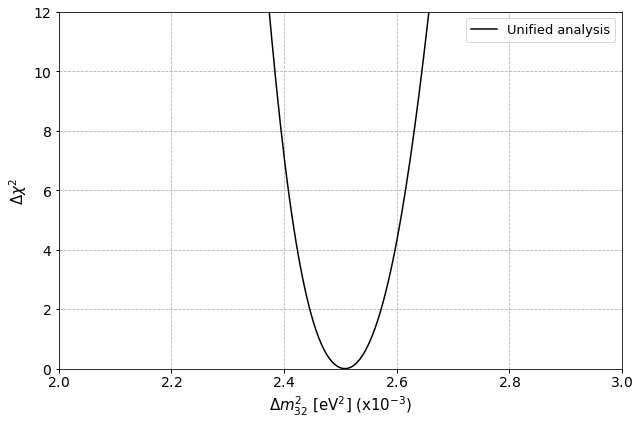

In [40]:
ploter_UNIFIED_profile(total_data,'dm32',1000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}


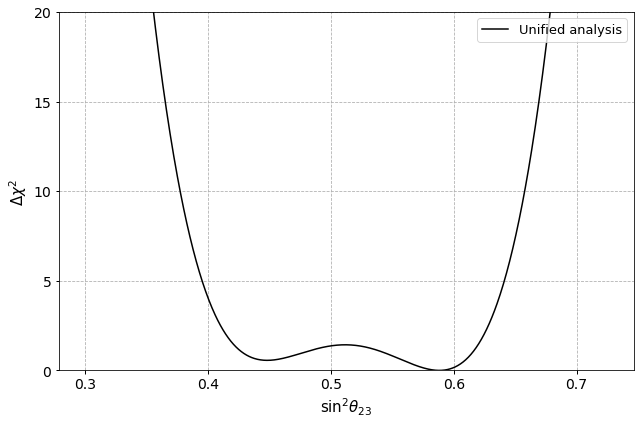

In [41]:
ploter_UNIFIED_profile(total_data,'s2_t23',1000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}


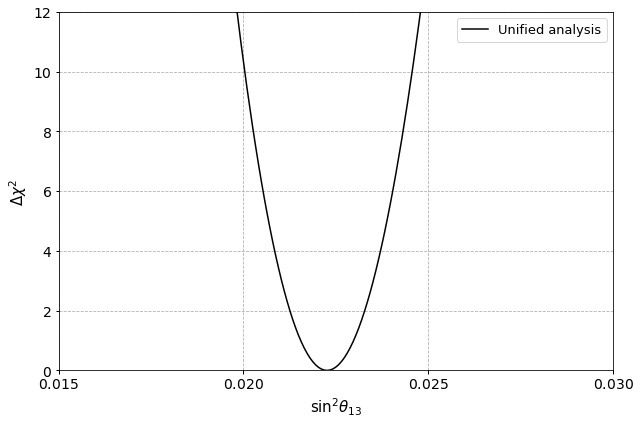

In [42]:
ploter_UNIFIED_profile(total_data,'s2_t13',1000)

## Unificado ( 2D vs $\Delta \chi^2$ )

In [43]:
def ploter_UNIFIED_confidence_regions(df,params,size):
    
    df = get_interpolated_data_2D(df,params,size)
    
    cl_68 = df[ (df['ji']  <=  2.30)  & (df['ji']  >=  2.15) ]   # 68.27 C.L. 
    #cl_90 = df[ (df['ji']  <=  4.61)  & (df['ji']  >=  4.51) ]
    cl_95 = df[ (df['ji']  <=  6.18)  & (df['ji']  >=  6.05) ]   # 95.45 C.L.
    cl_99 = df[ (df['ji']  <=  11.83) & (df['ji']  >=  11.65) ]  # 99.73 C.L.
    
    fig, ax = plt.subplots(figsize=(9,6))
    
    par =[]
    labels = []    
    if( ('dm32' in params) & ('s2_t13' in params) ):
        par.append('s2_t13')
        par.append('dm32')
        ax.set_xlim(0.018, 0.028)
        ax.set_xticks([0.018,0.02,0.022,0.024,0.026,0.028])
        ax.set_xticklabels(['$0.018$','$0.020$','$0.022$','$0.024$','$0.026$','$0.028$'])
        
        ax.set_ylim(0.002, 0.003)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        labels = [r'$\sin^2 \theta_{13}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']        
    elif( ('dm32' in params) & ('s2_t23' in params) ):
        par.append('s2_t23')
        par.append('dm32')     
        
        ax.set_xlim(0.3, 0.7)
        ax.set_xticks([0.3,0.4,0.5,0.6,0.7])
        ax.set_xticklabels(['$0.3$','$0.4$','$0.5$','$0.6$','$0.7$'])
        
        ax.set_ylim(0.002, 0.0030)   
        ax.set_yticks([0.002,0.0022,0.0024,0.0026,0.0028,0.0030])
        ax.set_yticklabels(['$2.0$','$2.2$','$2.4$','$2.6$','$2.8$','$3.0$'])
        
        labels = [r'$\sin^2 \theta_{23}$',r'$\Delta m^2_{32}$'+' [eV$^2$] (x10$^{-3}$)']
    elif( ('s2_t13' in params) & ('s2_t23' in params) ):
        par.append('s2_t13')
        par.append('s2_t23')        
        
        ax.set_xlim(0.018, 0.028)
        ax.set_xticks([0.018,0.02,0.022,0.024,0.026,0.028])
        ax.set_xticklabels(['$0.018$','$0.020$','$0.022$','$0.024$','$0.026$','$0.028$'])
        
        ax.set_ylim(0.3, 0.7)
        ax.set_yticks([0.3,0.4,0.5,0.6,0.7])
        ax.set_yticklabels(['$0.3$','$0.4$','$0.5$','$0.6$','$0.7$'])
        
        labels = [r'$\sin^2 \theta_{13}$',r'$\sin^2 \theta_{23}$']
    else:
        print('Opción no correcta')
    
    ax.scatter(par[0], par[1], data=cl_99, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_95, c='red',s=0.5)    
    #ax.scatter(par[0], par[1], data=cl_90, c='black',s=0.5)
    ax.scatter(par[0], par[1], data=cl_68, c='blue',s=0.5)
    
    ax.set(xlabel=labels[0], ylabel=labels[1],  title='Unified analysis')
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    
    ax.tick_params(labelcolor='black', labelsize=13, width=1)
    
    ax.grid(True,linestyle='--')
    fig.savefig('images/plot_UNIFIED_'+par[0]+'_'+par[1]+ '_vs_ji.png')
    return

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}


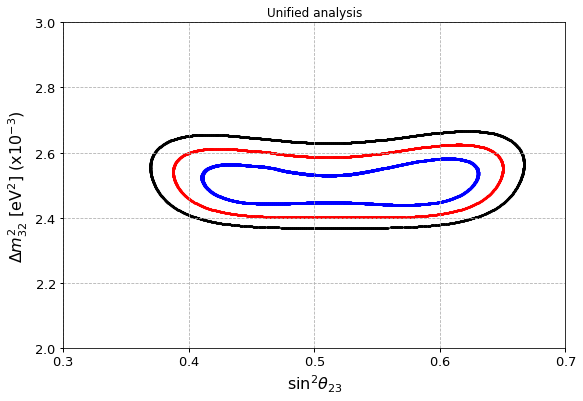

In [44]:
ploter_UNIFIED_confidence_regions(total_data,['dm32','s2_t23'],4000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}


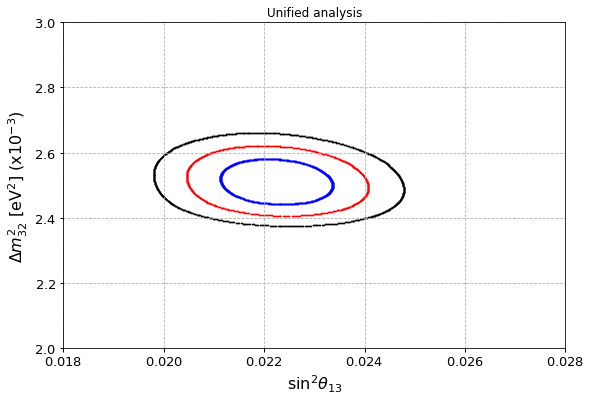

In [45]:
ploter_UNIFIED_confidence_regions(total_data,['dm32','s2_t13'],4000)

{'dm32_min': 0.0025, 's2_t13_min': 0.0225, 's2_t23_min': 0.5875, 'ji_min': 0.0}


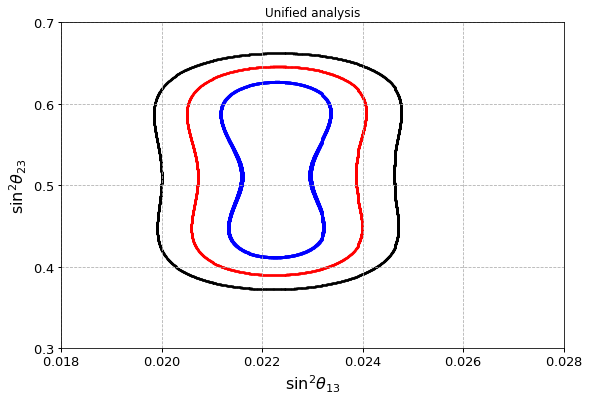

In [46]:
ploter_UNIFIED_confidence_regions(total_data,['s2_t23','s2_t13'],4000)